https://keras.io/api/layers/recurrent_layers/time_distributed/

## Yapılacaklar
- Train'de shuffle olması ok, ama test'te shuffle olmasın, test'i predict edince actuallarla comparable bir şey elde edeyim
- lagged y değerlerini feature olarak ekle

helal sana koçum ikisini de hallettin devam


### Resources 
- https://stackoverflow.com/questions/56858924/multivariate-input-lstm-in-pytorch
- https://github.com/danielhkt/deep-forecasting
    - main code is taken from here
- https://www.crosstab.io/articles/time-series-pytorch-lstm
- https://pangkh98.medium.com/multi-step-multivariate-time-series-forecasting-using-lstm-92c6d22cd9c2
    - Shifting of y
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/
    - seq2seq introduction
    - lstm autoregressive tasklarda çok iyi çalışmayabilir diyor, seq2seq'te encoder cnn decoder lstm kullanan bi approachtan bahsediyor
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
    - multistep lstm
    - multivariate lstm
    - multivariate & multistep lstm




In [1]:
import warnings; warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

2022-04-04 18:39:38.594302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-04 18:39:38.594321: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [95]:
df = pd.read_parquet("../data/processed/outlier_removed.parquet")
df = df[df["rt_plant_id"].isin([672, 968, 969])]

GENERATE_SPEED_ANGLE = True

weather_cols = [col for col in df.columns if col.startswith(("UGRD", "VGRD"))]

df = df.set_index("forecast_dt")[["rt_plant_id", "production", *weather_cols]]

if GENERATE_SPEED_ANGLE:
    for box in ["SW", "NW", "NE", "SE"]:
        df[f"speed_{box}"] = np.sqrt(np.square(df[f"UGRD_80.m.above.ground.{box}"]) + np.square(df[f"VGRD_80.m.above.ground.{box}"]))
        df[f"angle_{box}"] = np.arctan(df[f"UGRD_80.m.above.ground.{box}"] / df[f"VGRD_80.m.above.ground.{box}"])
        
time_indices = sorted(df.index.unique())
train_ratio = 0.8
valid_ratio = 0.1

train_indices = time_indices[:int(len(time_indices) * train_ratio)]
valid_indices = time_indices[int(len(time_indices) * train_ratio):int(len(time_indices) * (train_ratio + valid_ratio))]
test_indices = time_indices[int(len(time_indices) * (train_ratio + valid_ratio)):]

train_df = df.loc[train_indices, :]
valid_df = df.loc[valid_indices, :]
test_df = df.loc[test_indices, :]

PLANTS = sorted(df.rt_plant_id.unique())

def expand_plant_dimension(df):
    n_loc = len(PLANTS)
    n_time = df.index.nunique()
    cols = [col for col in df.columns if col != "rt_plant_id"]
    n_cols = len(cols)

    df_np = np.zeros((n_time, n_loc, n_cols))
    for i, plant_id in enumerate(PLANTS):
        df_np[:, i, :] = df[df.rt_plant_id == plant_id][cols].values
    return df_np

train_df_np = expand_plant_dimension(train_df)
valid_df_np = expand_plant_dimension(valid_df)
test_df_np = expand_plant_dimension(test_df)

scalers = {}
for i, plant in enumerate(PLANTS):
    scalers[plant] = MinMaxScaler()
    # train_df = pd.DataFrame(scaler.fit_transform(train_df), index=train_df.index, columns=train_df.columns)
    train_df_np[:, i, :] = scalers[plant].fit_transform(train_df_np[:, i, :])
    valid_df_np[:, i, :] = scalers[plant].transform(valid_df_np[:, i, :])
    test_df_np[:, i, :] = scalers[plant].transform(test_df_np[:, i, :])
    
train_df_np = np.array(train_df_np, dtype=np.float32)
valid_df_np = np.array(valid_df_np, dtype=np.float32)
test_df_np = np.array(test_df_np, dtype=np.float32)

# valid_df[valid_df["rt_plant_id"] == PLANTS[0]].iloc[0]
# scalers[PLANTS[0]].inverse_transform(valid_df_np[0])[0]

## 2D

In [96]:
print(train_df_np.shape)

(21117, 3, 17)


In [4]:
SELECTED_PLANT = 0

SELECTED_PLANT_ID = PLANTS[SELECTED_PLANT]

columns = [col for col in train_df.columns if col != "rt_plant_id"]

train_df_pd_0 = pd.DataFrame(train_df_np[:, SELECTED_PLANT], index=train_indices, columns=columns) 
valid_df_pd_0 = pd.DataFrame(valid_df_np[:, SELECTED_PLANT], index=valid_indices, columns=columns) 
test_df_pd_0 = pd.DataFrame(test_df_np[:, SELECTED_PLANT], index=test_indices, columns=columns) 


In [97]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, valid_df=valid_df, test_df=test_df,
                 columns=None, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.ndim = self.train_df.ndim
        assert self.ndim in [2, 3]
        if columns is None:
            columns = train_df.columns

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(columns)}
        # feature_column_indices = [v for k,v in self.column_indices.items() if k not in self.label_columns]
        # list(self.label_columns_indices.values())

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        # print(features.shape)
        if self.ndim == 2:
            # inputs = features[:, self.input_slice, :]
            # labels = features[:, self.labels_slice, :]
            inputs = features[:, self.input_slice, 1:]
            labels = features[:, self.labels_slice, :]
        else:
            inputs = features[:, self.input_slice, :, 1:]
            labels = features[:, self.labels_slice, :, :]
        if self.label_columns is not None:
            if self.ndim == 3:
                labels = tf.stack([labels[:, :, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
            else:
                labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        # print("labels: ", labels)
        # print("inputs.shape: ", inputs.shape, "\nlabels.shape: ", labels.shape)
        if self.ndim == 3:
            inputs.set_shape([None, self.input_width, None, None])
            labels.set_shape([None, self.label_width, None, None])
        else:
            inputs.set_shape([None, self.input_width, None])
            labels.set_shape([None, self.label_width, None])
        # print("inputs.shape: ", inputs.shape, "\nlabels.shape: ", labels.shape)
        return inputs, labels

    def plot(self, model=None, plot_col='production', plant=None, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue
            
            if self.ndim == 2:
                input_values = inputs[n, :, plot_col_index]
                label_values = labels[n, :, label_col_index]
            elif plant is not None:
                input_values = inputs[n, :, plant, plot_col_index]
                label_values = labels[n, :, plant, label_col_index]
            else:
                input_values = tf.math.reduce_mean(inputs[n, :, :, plot_col_index], axis=1)
                label_values = tf.math.reduce_mean(labels[n, :, :, label_col_index], axis=1)
                
            plt.plot(self.input_indices, input_values, label='Inputs', marker='.', zorder=-10)

                
            plt.scatter(self.label_indices, label_values, edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                if self.ndim == 2:
                    prediction_values = predictions[n, :, label_col_index]
                elif plant is not None:
                    prediction_values = predictions[n, :, plant, label_col_index]
                else:
                    prediction_values = tf.math.reduce_mean(predictions[n, :, :, label_col_index], axis=1)
                
                prediction_values = tf.clip_by_value(prediction_values, clip_value_min=0, clip_value_max=1)

                plt.scatter(self.label_indices, prediction_values,
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            # sequence_stride=24, shuffle=False,
            sequence_stride=1, shuffle=True,
            batch_size=64,)
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def valid(self):
        return self.make_dataset(self.valid_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [98]:
def wmape(y_true, y_pred):
    total_abs_diff = tf.reduce_sum(tf.abs(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(y_true)
    # print("-" * 20, "\t", total, "\t", "-" * 20, )
    # total = tf.clip_by_value(total, clip_value_min=1, clip_value_max=10**6)
    wmape = tf.realdiv(total_abs_diff, total)
    return wmape


MAX_EPOCHS = 20


def compile_and_fit(model, window, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min', 
        verbose=1,
        restore_best_weights=True)

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(), wmape]) 
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.valid,
                        verbose=1,
                        callbacks=[early_stopping])
    return history

In [99]:
if 0:
    OUT_STEPS = 24
    num_features = 16

    multi_window = WindowGenerator(
        train_df=train_df_pd_0, valid_df=valid_df_pd_0, test_df=test_df_pd_0,
        input_width=72, label_width=24, shift=0, label_columns=["production"])
    multi_window.plot()

In [100]:
columns = [col for col in train_df.columns if col != "rt_plant_id"]

multi_window2 = WindowGenerator(
    train_df=train_df_np, valid_df=valid_df_np, test_df=test_df_np, columns=columns,
    input_width=72, label_width=24, shift=0, label_columns=["production"])
multi_window2

Total window size: 72
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Label indices: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Label column name(s): ['production']

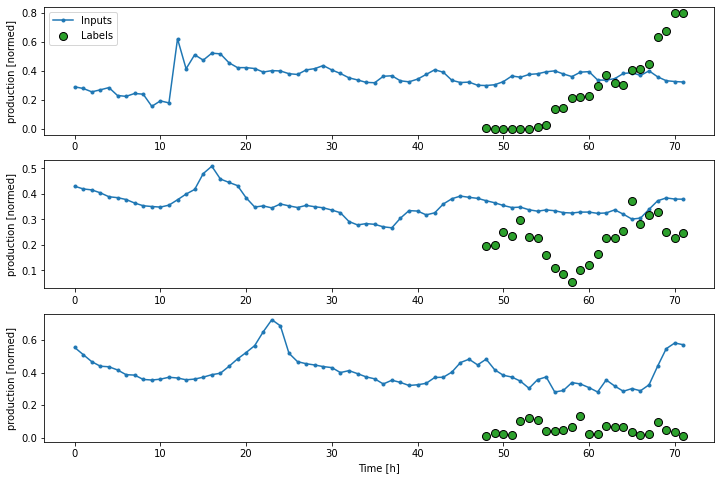

In [102]:
multi_window2.plot(plant=2)

In [103]:
multi_val_performance = {}
multi_performance = {}

## Dense

In [13]:
from tensorflow.keras import models, layers

In [ ]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(120, 16)))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Flatten())
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

history = compile_and_fit(model, multi_window)

In [ ]:
multi_val_performance['Linear1'] = model.evaluate(multi_window.valid)
multi_performance['Linear1'] = model.evaluate(multi_window.test, verbose=0)


In [ ]:
predictions = model.predict(multi_window.test)

In [ ]:
test_df[test_df["rt_plant_id"] == SELECTED_PLANT_ID]

In [ ]:
def calculate_wmape(actual, pred, scaler=None):
    if scaler is not None:
        actual = scaler.inverse_transform(np.array(actual).reshape(-1, 1)).copy()
        pred = scaler.inverse_transform(np.array(pred).reshape(-1, 1)).copy()
    print("Actual sum: ", actual.sum())
    return np.sum(np.abs(actual - pred)) / np.sum(actual)

In [ ]:
calculate_wmape(output["actuals"], output["predictions"], scaler_new)

In [ ]:
calculate_wmape(output["actuals"], output["predictions"])

In [ ]:
scaler_new.inverse_transform(actuals.reshape(-1, 1))

In [ ]:
predictions = model.predict(multi_window.test)
predictions = np.clip(predictions, 0, 1).reshape(-1, 1)
actuals = np.concatenate([y for x, y in multi_window.test], axis=0).reshape(-1, 1)

scaler_new = MinMaxScaler()
scaler_new.min_, scaler_new.scale_ = scalers[SELECTED_PLANT_ID].min_[0], scalers[SELECTED_PLANT_ID].scale_[0]
scaler_new.inverse_transform(actuals.reshape(-1, 1))

In [ ]:
output = pd.DataFrame()
output["predictions"] = predictions.reshape(-1)
output["actuals"] = actuals.reshape(-1)

In [ ]:
output.iloc[1500:].plot(figsize=(12,8))

In [14]:
model = models.Sequential()
model.add(layers.Reshape([94, 72, 16], input_shape=(72, 94, 16)))
model.add(layers.Dense(32, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Reshape([94, 32, 72]))
model.add(layers.Dense(8))
model.add(layers.Reshape([94, 8, 32]))
model.add(layers.Dense(3))
model.add(layers.Reshape([24, 94, 1]))
model.summary()

history = compile_and_fit(model, multi_window2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 94, 72, 16)        0         
                                                                 
 dense (Dense)               (None, 94, 72, 32)        544       
                                                                 
 reshape_1 (Reshape)         (None, 94, 32, 72)        0         
                                                                 
 dense_1 (Dense)             (None, 94, 32, 8)         584       
                                                                 
 reshape_2 (Reshape)         (None, 94, 8, 32)         0         
                                                                 
 dense_2 (Dense)             (None, 94, 8, 3)          99        
                                                                 
 reshape_3 (Reshape)         (None, 24, 94, 1)         0

KeyboardInterrupt: 

In [ ]:
multi_window2.plot(model, plant=4)

In [116]:
model = models.Sequential()
# model.add(layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :, :], input_shape=(72, 94, 17)))
# model.add(layers.Conv1D(64, CONV_WIDTH, activation='relu', input_shape=(24, 94, 17), padding="same"))
# model.add(layers.MaxPooling2D((1, 1)))
model.add(layers.Dense(32, kernel_initializer=tf.initializers.zeros(), input_shape=(72, 3, 16)))
# model.add(Permute((2, 1), input_shape=(10, 64)))
model.add(layers.Reshape([3, -1, 72]))
model.add(layers.Dense(24))
model.add(layers.Reshape([3, -1]))
model.add(layers.Dense(24))
# model.add(layers.Dense(OUT_STEPS))
# model.add(layers.Flatten())
# model.add(layers.Reshape([94, 24*CONV_WIDTH]))
# model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Reshape([24, 3, 1]))
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 72, 3, 32)         544       
                                                                 
 reshape_40 (Reshape)        (None, 3, 32, 72)         0         
                                                                 
 dense_46 (Dense)            (None, 3, 32, 24)         1752      
                                                                 
 reshape_41 (Reshape)        (None, 3, 768)            0         
                                                                 
 dense_47 (Dense)            (None, 3, 24)             18456     
                                                                 
 reshape_42 (Reshape)        (None, 24, 3, 1)          0         
                                                                 
Total params: 20,752
Trainable params: 20,752
Non-tra

In [117]:
history = compile_and_fit(model, multi_window2)

Epoch 1/20
329/329 [==============================] - 1s 3ms/step - loss: 0.0817 - mean_absolute_error: 0.2306 - wmape: 0.6723 - val_loss: 0.0781 - val_mean_absolute_error: 0.2242 - val_wmape: 0.5243
Epoch 2/20
329/329 [==============================] - 1s 3ms/step - loss: 0.0718 - mean_absolute_error: 0.2126 - wmape: 0.6206 - val_loss: 0.0751 - val_mean_absolute_error: 0.2223 - val_wmape: 0.5217
Epoch 3/20
329/329 [==============================] - 1s 3ms/step - loss: 0.0703 - mean_absolute_error: 0.2096 - wmape: 0.6115 - val_loss: 0.0715 - val_mean_absolute_error: 0.2179 - val_wmape: 0.5122
Epoch 4/20
329/329 [==============================] - 1s 3ms/step - loss: 0.0700 - mean_absolute_error: 0.2090 - wmape: 0.6105 - val_loss: 0.0741 - val_mean_absolute_error: 0.2186 - val_wmape: 0.5104
Epoch 5/20
329/329 [==============================] - 1s 3ms/step - loss: 0.0695 - mean_absolute_error: 0.2082 - wmape: 0.6087 - val_loss: 0.0688 - val_mean_absolute_error: 0.2147 - val_wmape: 0.5038


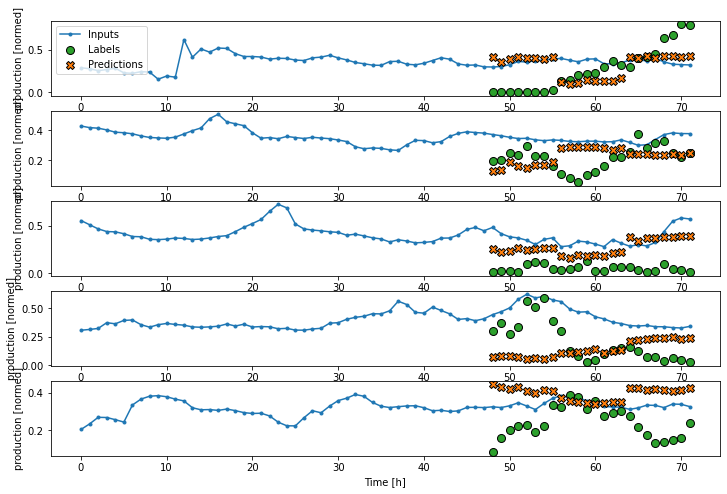

In [118]:
multi_window2.plot(model, plant=2, max_subplots=5)

In [119]:
multi_val_performance['Linear2'] = model.evaluate(multi_window2.valid)
multi_performance['Linear2'] = model.evaluate(multi_window2.test)


41/41 [==============================] - 0s 2ms/step - loss: 0.1081 - mean_absolute_error: 0.2595 - wmape: 0.5817


In [111]:
predictions = model.predict(multi_window2.test)
predictions = np.clip(predictions, 0, 1)
actuals = np.concatenate([y for x, y in multi_window2.test], axis=0)

def calculate_wmape(actual, pred):
    return np.sum(np.abs(actual - pred)) / np.sum(actual)

wmape_dict = {}
for i in range(3):
    p = predictions[:, :, i, :]
    a = actuals[:, :, i, :]
    wmape_dict[i] = calculate_wmape(a, p)
    

In [112]:
pd.DataFrame(wmape_dict, index=["wmape"]).T.sort_values("wmape")

,wmape
1,0.757251
0,0.781520
2,0.795405


In [115]:
pd.DataFrame(wmape_dict, index=["wmape"]).T.wmape.mean()

0.7780586

In [ ]:
# multi_linear_model.predict(multi_window.train)[0].shape

In [ ]:
# multi_linear_model.summary()

In [ ]:
multi_linear_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear2'] = multi_linear_model.evaluate(multi_window.valid)
multi_performance['Linear2'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)


## Convolutional

In [ ]:
multi_window2.train_df.shape

In [ ]:
from tensorflow.keras import datasets, layers, models

CONV_WIDTH = 3
model = models.Sequential()
model.add(layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :, :], input_shape=(72, 94, 17)))
model.add(layers.Conv1D(64, CONV_WIDTH, activation='relu', input_shape=(24, 94, 17), padding="same"))
model.add(layers.MaxPooling2D((1, 1)))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Flatten())
model.add(layers.Reshape([94, 24*CONV_WIDTH]))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Reshape([24, 94, 1]))


# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.summary()


In [ ]:
history = compile_and_fit(model, multi_window2)

In [ ]:
multi_val_performance['Conv1'] = model.evaluate(multi_window2.valid)
multi_performance['Conv1'] = model.evaluate(multi_window2.test, verbose=0)
multi_window2.plot(model)

In [ ]:
multi_val_performance = {}
multi_performance = {}

In [ ]:
multi_window2.plot(model)

In [ ]:
multi_window2.plot(model, plant=0)

In [ ]:
multi_window2.plot(model, plant=4)

In [ ]:
multi_window2.plot(model, plant=0, max_subplots=5)

In [ ]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :, :], input_shape=(10000, 94, 17)))
# model.add(layers.Conv2D(32, (7, 7), activation='relu', input_shape=(7, 94, 17), padding="same"))
model.add(layers.Conv2D(32, (7, 7), activation='relu', input_shape=(7, 94, 17), padding="valid"))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.summary()


In [ ]:
CONV_WIDTH = 7
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv1'] = multi_conv_model.evaluate(multi_window.valid)
multi_performance['Conv1'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
CONV_WIDTH = 7
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv2'] = multi_conv_model.evaluate(multi_window.valid)
multi_performance['Conv2'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
CONV_WIDTH = 12
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv3'] = multi_conv_model.evaluate(multi_window.valid)
multi_performance['Conv3'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
CONV_WIDTH = 24
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # tf.keras.layers.Conv1D(16, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    # tf.keras.layers.Conv1D(16, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.Conv1D(1024, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv4'] = multi_conv_model.evaluate(multi_window.valid)
multi_performance['Conv4'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
CONV_WIDTH = 24
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)), 
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv4'] = multi_conv_model.evaluate(multi_window.valid)
multi_performance['Conv4'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

## RNN

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['RNN1'] = multi_lstm_model.evaluate(multi_window.valid)
multi_performance['RNN1'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


In [ ]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['RNN2'] = multi_lstm_model.evaluate(multi_window.valid)
multi_performance['RNN2'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


In [ ]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['RNN3'] = multi_lstm_model.evaluate(multi_window.valid)
multi_performance['RNN3'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


In [ ]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['RNN4'] = multi_lstm_model.evaluate(multi_window.valid)
multi_performance['RNN4'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


In [ ]:
CONV_WIDTH = 12
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['ConvLSTM1'] = multi_conv_model.evaluate(multi_window.valid)
multi_performance['ConvLSTM1'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
CONV_WIDTH = 12
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['ConvLSTM2'] = multi_conv_model.evaluate(multi_window.valid)
multi_performance['ConvLSTM2'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
def plot_metrics(sort_test=True):
    plt.figure(figsize=(12, 15))
    x = np.arange(len(multi_performance))
    width = 0.3
    
    for n in range(len(multi_linear_model.metrics_names)):
        plt.subplot(len(multi_linear_model.metrics_names), 1, n+1)
        metric_name = multi_linear_model.metrics_names[n]
        val_mae = [v[n] for v in multi_val_performance.values()]
        test_mae = [v[n] for v in multi_performance.values()]
        
        if sort_test:
            sorted_index = np.argsort(test_mae)
        else:
            sorted_index = np.argsort(val_mae)
        val_mae = [val_mae[i] for i in sorted_index]
        test_mae = [test_mae[i] for i in sorted_index]

        plt.bar(x - 0.17, val_mae, width, label='Validation')
        plt.bar(x + 0.17, test_mae, width, label='Test')
        plt.xticks(ticks=x, labels=[list(multi_performance.keys())[i] for i in sorted_index], rotation=45)
        plt.ylabel(metric_name)
        plt.title(metric_name)
        if n == 0:
            _ = plt.legend()

In [ ]:
plot_metrics()

In [ ]:
plot_metrics(False)

In [ ]:
multi_performance